In [1]:
# korekta błędu w Keras po zmianie w bibliotece numpy
import numpy as np
np_load_old = np.load
np.load = lambda *a, **k: np_load_old(*a, allow_pickle=True, **k)

# wyłączenie ostrzeżeń
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [3]:
from keras import backend as K
K.clear_session()

# Generowanie obrazów przy użyciu wariacyjnych autoenkoderów

(...)


## Wariacyjne autoenkodery


Wariacyjne autoenkodery zostały opracowane jednocześnie przez Kingmę i Wellinga w grudniu 2013 r.  i Rezende, Mohameda i Wierstrę w styczniu 2014 r. Są to generatywne modele sprawdzające się szczególnie w zadaniach edycji obrazu przy użyciu wektorów koncepcyjnych. Wariacyjne autoenkodery to nowoczesne podejście do autoenkoderów — sieci, która ma na celu zakodowanie danych wejściowych w postaci niskopoziomowej niejawnej przestrzeni, a następnie ich dekodowanie — jest to połączenie uczenia głębokiego z wnioskowaniem bayesowskim.

Klasyczny autoenkoder obrazu przetwarza obraz wejściowy, mapuje go na niejawną przestrzeń wektorową z zastosowaniem modułu kodera, a następnie dekoduje go do postaci wejściowej o takich samych wymiarach jak obraz oryginalny przy użyciu modułu dekodera. Autoenkoder jest trenowany tak, aby mógł dokonać rekonstrukcji obrazów wejściowych. Nakładając różne ograniczenia na wyjście kodera, można zmusić autoenkoder do uczenia się interesujących nas niejawnych reprezentacji danych. Zwykle kod ma być niskopoziomowy i rzadki (powinien zawierać głównie zera). W takim przypadki koder działa tak, jakby kompresował dane wejściowe do postaci formy składającej się z kilku bitów informacji.

![Autoencoder](img\8_4a.png)


W praktyce takie klasyczne autoenkodery nie pozwalają na uzyskanie szczególnie przydatnej przestrzeni o ładnej strukturze. Nie są one również zbyt wydajne w roli mechanizmów kompresji danych. W związku z tym wyszły one z użycia. Technika kodowania VAE usprawniła działanie autoenkoderów dodając do nich nieco magii statystyki, dzięki której są one w stanie uczyć się ciągłych przestrzeni charakteryzujących się określoną strukturą. W ten sposób powstało solidne narzędzie służące do generowania obrazów.

Koder VAE zamiast kompresować obraz wejściowy do określonej formy kodu niejawnej przestrzeni, zamienia obraz w parametry rozkładu statystycznego: średnią i wariancję. Oznacza to założenie, że obraz wejściowy został wygenerowany przez proces statystyczny i podczas kodowania i dekodowania należy wziąć pod uwagę losowość tego procesu. Koder VAE korzysta następnie z parametrów średniej i wariancji w celu losowego próbkowania jednego elementu rozkładu i zdekodowania go z powrotem do oryginalnej postaci. Stochastyczność tego procesu poprawia jego siłę i zmusza niejawną przestrzeń do zapisywania wszędzie reprezentacji mających znaczenie: każdy punkt próbkowany w tej przestrzeni jest dekodowany do postaci poprawnego obiektu wejściowego.

![VAE](img\8_4b.png)


Z technicznego punktu widzenia koder VAE działa w następujący sposób:

1.	Moduł kodera zamienia próbki wejściowe input_img na dwa parametry niejawnej przestrzeni reprezentacji: z_mean i z_log_variance.
2.	Punkt z jest losowo próbkowany z niejawnego rozkładu normalnego, co ma doprowadzić do wygenerowania obrazu wejściowego za pomocą działania z = z_mean + exp(z_log_variance) * epsilon, gdzie epsilon jest losowym tensorem o małych wartościach.
3.	Moduł dekodera mapuje ten punkt w niejawnej przestrzeni z powrotem na formę oryginalnego obrazu.

Współczynnik epsilon przyjmuje wartość losową, a więc proces zapewnia to, że każdy punkt zbliżony w niejawnej przestrzeni do punktu, w którym zakodowano obraz input_img(z-mean) po rozkodowaniu będzie wyglądał podobnie do obrazu input_img (niejawna przestrzeń będzie miała charakter sensowny i ciągły). Po zdekodowaniu dowolnych dwóch zbliżonych do siebie punktów niejawnej przestrzeni uzyskamy bardzo podobne do siebie obrazy. Ciągłość w połączeniu z małą liczbą wymiarów niejawnej przestrzeni sprawia, że każdy kierunek tej przestrzeni tworzy oś zmienności danych o konkretnym znaczeniu — niejawna przestrzeń ma charakter wysoce ustrukturyzowany i łatwo poruszać się w niej przy użyciu wektorów koncepcji.

Parametry kodera VAE są trenowane przy użyciu dwóch funkcji straty: straty rekonstrukcji, która wymusza dopasowanie dekodowanych próbek do obrazów wejściowych, i straty regularyzacji, która wspiera tworzenie niejawnych przestrzeni o poprawnej formie, a także umożliwia zmniejszenie nadmiernego dopasowania do treningowego zbioru danych. Przeanalizujmy szybko implementację kodera VAE w pakiecie Keras. Schematycznie wygląda ona tak:

In [4]:
# Kodowanie obrazu wejściowego za pomocą parametrów średniej i wariancji.
z_mean, z_log_variance = encoder(input_img)

# Wyciąganie punktu z przestrzeni przy użyciu małej losowej wartości epsilon.
z = z_mean + exp(z_log_variance) * epsilon

# Dekodowanie — tworzenie obrazu.
reconstructed_img = decoder(z)

# Tworzenie instancji modelu autoenkodera mapującego obraz wejściowy na jego rekonstrukcję.
model = Model(input_img, reconstructed_img)


NameError: name 'encoder' is not defined

Model jest następnie trenowany z wykorzystaniem dwóch funkcji straty: straty rekonstrukcji i straty regularyzacji.
Poniższy kod pokazuje sieć kodera mapującą obrazy na parametry rozkładu prawdopodobieństwa umieszczone w przestrzeni o niejawnym charakterze. W praktyce jest to prosta sieć konwolucyjna przypisująca obraz wejściowy x do dwóch wektorów: z_mean i z_log_var.

In [5]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Liczba wymiarów niejawnej przestrzeni: pracujemy z przestrzenią dwuwymiarową.

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Oto kod pozwalający na użycie parametrów rozkładu statystycznego z_mean i z_log_var, które z założenia mają pozwalać na utworzenie obrazu input_img w celu wygenerowania punktu z niejawnej przestrzeni. Część kodu zbudowanego na bazie zaplecza pakietu Keras obudowujemy warstwą Lambda. W Keras wszystko musi być warstwą, a więc kod, który nie należy do wbudowanej warstwy, powinien mieć formę warstwy Lambda lub innej samodzielnie zdefiniowanej warstwy.

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])


Poniższy fragment kodu przedstawia implementację dekodera. Wektor z jest modyfikowany tak, aby uzyskał wymiary obrazu, a następnie używanych jest kilka warstw konwolucyjnych w celu wygenerowania ostatecznej postaci obrazu wyjściowego mającego takie same wymiary jak oryginalny obraz input_img.

In [7]:
# Wejście wektora z.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Zwiększanie rozdzielczości obiektu wejściowego.
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Zmiana kształtu wektora w celu uzyskania map cech o takim samym kształcie jak kształt mapy cech przed ostatnią warstwą Flatten modułu kodującego.
x = layers.Reshape(shape_before_flattening[1:])(x)

# Warstwy Conv2DTranspose i Conv2D są używane w celu 
# odkodowania wektora z do formy mapy cech o takim samym rozmiarze
# jak oryginalny obraz wejściowy.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)


# Tworzenie instancji modelu dekodera zamieniajacego obiekt decoder_input na zdekodowany obraz.
decoder = Model(decoder_input, x)

# Przyjmuje wektor z i zwraca jego zdekodowaną postać.
z_decoded = decoder(z)

Dualizm funkcji straty kodera VAE nie wpasowuje się w tradycyjne ramy funkcji próbującej w formie loss(input, target). W związku z tym zdefiniujemy dodatkową warstwę, która będzie wewnętrznie korzystać z metody add_loss w celu wygenerowania wartości straty.

In [8]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # Nie korzystamy z tych zwracanych danych, ale warstwa musi coś zwracać.
        return x

# Wywołujemy własną warstwę na obiekcie wejściowym i odkodowanym obiekcie wyjściowym 
# w celu wygenerowania ostatecznego obiektu generowanego przez model.
y = CustomVariationalLayer()([input_img, z_decoded])


Teraz możemy utworzyć instancję modelu i ją wytrenować. Wartością straty zajęliśmy się w utworzonej ręcznie warstwie, a więc nie musimy określać zewnętrznej funkcji straty w czasie kompilacji (loss=None), co z kolei oznacza, że nie będziemy przekazywać docelowych danych w czasie trenowania (do funkcji fit modelu przekazujemy tylko argument x_train).

In [9]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Trenowanie kodera VAE na zbiorze cyfr MNIST.
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (


Po wytrenowaniu modelu na zbiorze MNIST możemy użyć sieci decoder w celu wygenerowania obrazów na podstawie dowolnej niejawnej przestrzeni wektorów:

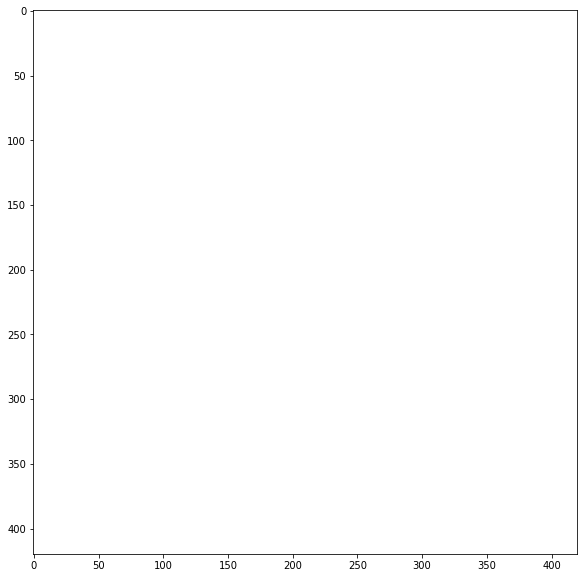

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Wyświetlamy siatkę 15x15 cyfr (łącznie 255 cyfr).
n = 15  
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Transformacja liniowych współrzędnych przy użyciu funkcji ppf pakietu SciPy 
# w celu wygenerowania wartości niejawnej zmiennej z (pracujemy z przestrzenią Gaussa).
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Wygenerowana siatka cyfr pokazuje całkowitą ciągłość rozkładu różnych klas cyfr — na kolejnych obrazach widać, że cyfry stopniowo przechodzą w siebie. Kierunki w tej przestrzeni mają znaczenie: podążając w jednym z wybranych kierunków, otrzymujemy obraz przypominający bardziej cyfrę 4, a podrażając w innym otrzymujemy obraz przypominający bardziej cyfrę 1 itd.